# LCPB 22-23 Exercise 1 (Gradient descent & Deep Neural Networks, DNNs) 


<center><h1>Group 2307</h1></center>


<center><style>
table {
    font-size: 24px;
}
</style></center>

| Last Name          | First Name            |Matricola number|
|--------------------|-----------------------|----------------|
| Bertinelli         | Gabriele              |1219907 (tri)   |
| Cacciola           | Martina               |2097476         |
| Pervysheva         | Yelyzaveta            |2039398         |           
| Waththe Liyanage   | Wageesha Widuranga    |2078719         |




## Overview

In this assignment, we will analyze labeled 2D data x=(x1,x2) introduced in the second lesson using Deep Neural Networks (DNNs) and gradient descent. The main goals of the assignment are:

1. Implement a "grid search" to improve at least two aspects or hyperparameters of the model.
2. Take the best DNN from point 1 and study how its performance changes when the number N of samples is a) reduced, b) increased, or c) augmented.
3. Optionally, we will explore what happens with data generated by the second nonlinear function or other choices.

### Implementation Details

#### Grid Search
To improve the DNN model, we will implement a "grid search" technique, as shown in the Mehta et al. notebook NB11, where we will explore different hyperparameters of the model. We will focus on at least two aspects, such as the choice of the minimization algorithm (ADAM, RMSprop, Nesterov, etc.), activation units (sigmoid, ReLU, ELU, etc.), dropout values, learning rate, size or number of layers, and rescaling of data.

#### Performance Analysis
After improving the DNN model, we will analyze how its performance changes with different sample sizes, including reduced, increased, and augmented datasets. For the augmented dataset, we will generate artificial training samples similar to the real ones, where each sample x=(x1,x2) is transformed to multiple copies (x1+s1, x2+s2), where each (s1,s2) is a reasonably slight random shift. We will also explain our choice for the variability of this shift and why we do not augment the validation samples.

#### Optional Exploration
Optionally, we will explore what happens with data generated by the second nonlinear function or other choices.


In [145]:
from __future__ import print_function
import keras, sklearn
import tensorflow as tf
import numpy as np
seed=0
np.random.seed(seed)
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load Dataset

The dataset is generated by randomly generating 4000 data points with coordinates following a uniform distribution in the range of -50 to +50. The points are labeled with a value of 1 if they satisfy all three boundary conditions, and 0 otherwise.

In [146]:
x = np.loadtxt('../Exercises/E1/DATA/data-for-DNN-1.dat')
y = np.loadtxt('../Exercises/E1/DATA/labels-for-DNN-1.dat')

# Plot Dataset

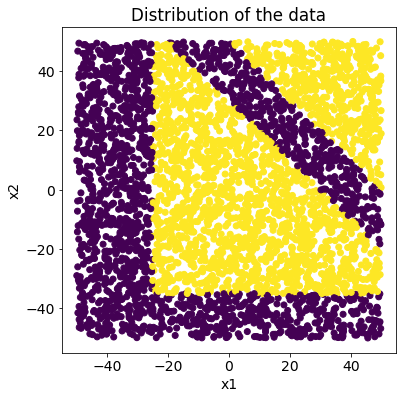

In [147]:
plt.figure(figsize = (6, 6))
plt.scatter(x[:,0], x[:,1], c=y, marker='o')
plt.title('Distribution of the data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [148]:
# from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam
from keras.optimizers import adam_v2, rmsprop_v2, nadam_v2
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
import numpy as np


# Define size of the training set

In this code, we define the proportion of the original dataset to be used as training data using the variable `Per_train` (here set to 0.8, i.e., 80% of the data), and we calculate the number of samples in the original dataset using N and the number of features (dimensionality) of each sample using L.

In [149]:
Per_train = 0.8

N = len(x)
L = len(x[0])
N_train = int(Per_train*N)

print("Number of samples in dataset:", N)
print("Number of samples in train data:", N_train)

Number of samples in dataset: 4000
Number of samples in train data: 3200


# Spliting Training and Validation data

We split the data betweet training and validation set, based on the `Per_train` value.  
We shuffle the two new dataset in anticipation of forming mini-batches. This is an important step in order to prevent that the gradient method can fit spurious correlations resulting from the order in which data is presented.

In [150]:
from sklearn.utils import shuffle

(x_train, y_train) = (x[0:N_train], y[0:N_train])
(x_valid, y_valid) = (x[N_train:], y[N_train:])

# shuffle the data
(x_train, y_train), (x_valid, y_valid) = shuffle(x_train, y_train), shuffle(x_valid, y_valid)

print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 3200 	 Validation: 800


# Model Creation

1. _optimizer_: the optimization algorithm used to train the model, with a default value of Adam optimizer.
2. _activation_: the activation function used for the hidden layers of the network, with a default value of ReLU.
3. _dropout_rate_: the rate at which randomly dropout connections between neurons during training, with a default value of 0.2.

The model consists of an input layer, two hidden layers with 20 neurons each and the specified activation function, a dropout layer to prevent overfitting, and an output layer with a sigmoid activation function for binary classification.

The model is compiled using binary cross-entropy loss and accuracy as the evaluation metric. Finally, the model is returned.

In [151]:
def created_model(optimizer= adam_v2.Adam(), activation='relu', dropout_rate=0.2):
    
    model = Sequential() 
    model.add(Dense(L, input_shape=(L,), activation=activation))
    model.add(Dense(20, activation=activation))  
    model.add(Dense(20, activation=activation))
    model.add(Dropout(dropout_rate)) 
    model.add(Dense(1, activation='sigmoid'))
    
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

# Best Optimizer

Here we use _grid search cross-validation_ to find the best optimizer algorithm to use for our NN model. 
We create a `KerasClassifier` object with the `created_model` function we defined earlier, and set the number of epochs to 60 and the batch size to 64. We then define a parameter grid to search over, which includes different optimizer algorithms.


In summary, we use grid search cross-validation to find the best optimizer algorithm to use for our NN model, and store the best optimizer found.

The best optimizer is printed with its mean test score and the std deviation between (). The optimizer tested can be found in the `optimizer` list below.

In [152]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR) # this goes *before* tf import

import tensorflow as tf
tf.autograph.set_verbosity(0)

batch_size = 64

model_gridsearch = KerasClassifier(build_fn=created_model, 
                        epochs=60, 
                        batch_size=batch_size, 
                        verbose=False)

optimizer = ['SGD', 'RMSprop', 'Adagrad','Adam', 'Adamax', 'Nadam']

# define parameter dictionary
param_grid = dict(optimizer=optimizer)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train)

# summarize results
# print the best optimizer
print("Best: %f using %s\n" % (grid_result.best_score_, grid_result.best_params_))

# print mean test score, std deviation in () and the name of the optimizer
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# store the best optimizer    
best_optimizer = grid_result.best_params_['optimizer']

Best: 0.805937 using {'optimizer': 'Adam'}

0.690625 (0.048432) with: {'optimizer': 'SGD'}
0.759062 (0.033112) with: {'optimizer': 'RMSprop'}
0.652187 (0.029612) with: {'optimizer': 'Adagrad'}
0.805937 (0.020905) with: {'optimizer': 'Adam'}
0.734375 (0.041444) with: {'optimizer': 'Adamax'}
0.754063 (0.070464) with: {'optimizer': 'Nadam'}


# Best Batch Size

Here, we are tuning the hyperparameter _batch size_ for the NN model. We create a `KerasClassifier` object with the `created_model` function, and set the number of epochs and verbose parameters. 
We then define a range of batch sizes to test and create a grid search object using `GridSearchCV` from `scikit-learn`. 
We fit the grid search object to our training data and print out the best mean test score and corresponding hyperparameters. We also print out the mean test score, standard deviation, and hyperparameters for each batch size tested. 
Finally, we extract the best batch size found by the grid search.

<!--- The result shows that the best mean test score of 0.802187 was achieved with a batch size of 64. The other batch sizes tested, in descending order of mean test score, were 32 and 128. The standard deviation of the test scores is also provided for each batch size. -->

Batch size is an important hyperparameter in NN training. A larger batch size may result in a faster convergence and better optimization, but may also require more memory and slower training time. In contrast, a smaller batch size may require less memory and have faster training time, but may result in a slower convergence and suboptimal optimization.

`# The best batch size depends on the epochs value. if it's 50, the best batch is 64. if it's 60, the best is 32`  
`# I think the best way is to be consistent w/ the epochs value of the very first NN, aka epochs=60`

In [153]:
model_gridsearch = KerasClassifier(build_fn=created_model, 
                        epochs=50, 
                        batch_size=batch_size, 
                        verbose=False)


batch_size = [32, 64, 128]


param_grid = dict(batch_size=batch_size)

grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train)

# summarize results
print("Best: %f using %s\n" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
best_batch_size = grid_result.best_params_['batch_size']

Best: 0.825000 using {'batch_size': 32}

0.825000 (0.053873) with: {'batch_size': 32}
0.760000 (0.059022) with: {'batch_size': 64}
0.769688 (0.047716) with: {'batch_size': 128}


# Droupout Value

The best _dropout rate_ is then selected based on the mean test score.

The model is created with the previously optimized batch size, and an epoch of 50. The dropout rate is set to a list of four values: 0.1, 0.2, 0.3, and 0.4. We use GridSearchCV to perform a 4-fold cross-validation on each of the dropout rates in the list, and the best dropout rate is returned.

`# I think we should use epochs=60`

The results show the mean test score and standard deviation of the test scores for each dropout rate. The best dropout rate found by the grid search is printed along with its corresponding mean test score.

In [154]:
batch_size = best_batch_size

model_gridsearch = KerasClassifier(build_fn=created_model, 
                        epochs=50, 
                        batch_size=batch_size, 
                        verbose=False)


dropout_rate = [0.1, 0.2, 0.3, 0.4]

param_grid = dict(dropout_rate=dropout_rate)


grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

best_dropout_rate = grid_result.best_params_['dropout_rate']

Best: 0.794062 using {'dropout_rate': 0.4}
0.792187 (0.054223) with: {'dropout_rate': 0.1}
0.767812 (0.048721) with: {'dropout_rate': 0.2}
0.787813 (0.052999) with: {'dropout_rate': 0.3}
0.794062 (0.066370) with: {'dropout_rate': 0.4}


# Best Activation Function

_Activation functions_ are mathematical equations that determine the output of a neural network model. Different activation functions have different effects on the performance and convergence of the model.

The results shown indicate that `ReLU` is the best activation function for our model, as it has the highest mean accuracy and a relatively low standard deviation. This means that `ReLU` is able to produce consistent and accurate outputs for our data.

Some possible reasons why `ReLU` is better than other activation functions are:

- ReLU is simple and computationally efficient.
- ReLU avoids the _vanishing gradient problem_ that affects sigmoid and tanh.
- ReLU can handle sparse data better than linear or softmax.

In [155]:
batch_size = 64
model_gridsearch = KerasClassifier(build_fn=created_model, 
                        epochs=50, 
                        batch_size=batch_size, 
                        verbose=False)


activation = ['softmax', 'softsign', 'relu', 'tanh', 'sigmoid', 'linear']

param_grid = dict(activation=activation)

grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=2, cv=4)
grid_result = grid.fit(x_train,y_train)

#summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

best_activation = grid_result.best_params_['activation']

Best: 0.774687 using {'activation': 'relu'}
0.738125 (0.059085) with: {'activation': 'softmax'}
0.742188 (0.055244) with: {'activation': 'softsign'}
0.774687 (0.031205) with: {'activation': 'relu'}
0.703438 (0.055081) with: {'activation': 'tanh'}
0.743750 (0.055755) with: {'activation': 'sigmoid'}
0.674063 (0.021275) with: {'activation': 'linear'}


# Model with best Parameters

Our best model has the following structure:

- An input layer with L nodes, where L is the dimension of our input data. This layer uses an activation function that we have chosen as the best one for our problem (`best_activation`).
- Two hidden layers with 20 nodes each, using the same activation function as the input layer (`best_activation`).
- A dropout layer with a dropout rate that we have chosen as the best one for our problem (`best_dropout_rate`). This layer randomly drops out some nodes during training to prevent overfitting.
- An output layer with one node, using a `sigmoid` activation function. This layer produces a binary output (0 or 1) for our classification problem.
- A loss function of `binary crossentropy`, which measures how well the model predicts the true labels of our data.
- An optimizer that we have chosen as the best one for our problem (`best_optimizer`), which updates the weights of our model based on the gradients of the loss function.
- A metric of `accuracy`, which measures how many predictions our model gets right on the data.

We now train our best NN model on `x_train` and `y_train` data for 450 epochs, using a batch size that we have chosen as the best one for your problem (`best_batch_size`). We have also validate our model on `x_valid` and `y_valid` data during training to monitor its performance.

In [156]:
# Creating and training the NN model w/ our best parameters
epochs = 450

best_model = Sequential() 

activation = best_activation
best_model.add(Dense(L, input_shape=(L,), activation=activation))
best_model.add(Dense(20, activation=activation))  
best_model.add(Dense(20, activation=activation))

dropout_rate = best_dropout_rate
best_model.add(Dropout(dropout_rate))
best_model.add(Dense(1, activation='sigmoid'))

optimizer = best_optimizer

best_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

batch_size = best_batch_size


# Fitting again with more data
fit = best_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_valid, y_valid), verbose=False)

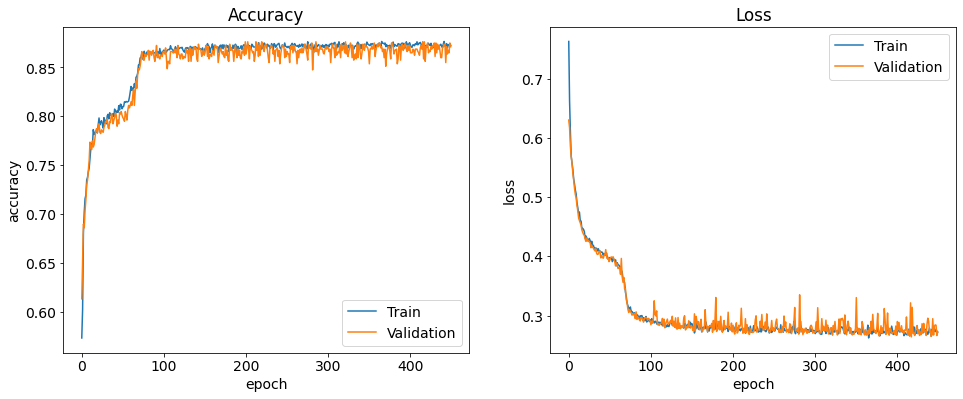

In [157]:
# Creating the plot
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Accuracy in training and validation
ax1.plot(fit.history['accuracy'])
ax1.plot(fit.history['val_accuracy'])

# Setting labels and legend
ax1.set_title('Accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['Train', 'Validation'])

# Loss in training and validation
ax2.plot(fit.history['loss'])
ax2.plot(fit.history['val_loss'])

# Setting labels and legend
ax2.set_title('Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['Train', 'Validation'])

plt.show()

The best valadation accuracy, 0.877, was achieved on the 365th epoch.


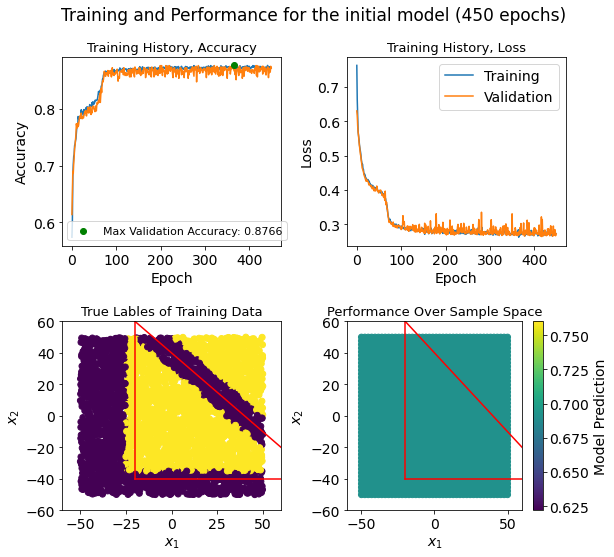

In [158]:
# Defining a grid to represent the sample space
dX = 2 #number of dimensions of the data
LG = int(np.sqrt(4000/2))
x1 = np.linspace(-50,50,LG)
x2 = np.linspace(-50,50,LG)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(x1[j],x2[i])
        k=k+1

# Rescaling grid points
grid_r = grid/50

# Performing a prediction on grid points
pred = best_model.predict(grid_r)

# Best validation accuracy
plt.rcParams['font.size'] = 14
max_val_acc = np.max(fit.history['accuracy'])
max_val_epoch = np.argmax(fit.history['accuracy'])
print('The best valadation accuracy, %.3f, was achieved on the %uth epoch.' %(max_val_acc, max_val_epoch))

# perfomance vs epochs plot
fig, AX=plt.subplots(2, 2, figsize=(7, 7))
fig.suptitle('Training and Performance for the initial model (450 epochs)', y=1, fontsize=17)
ax=AX[0][0]
ax.set_title('Training History, Accuracy', fontsize=13)

mystring = "Max Validation Accuracy: "+str(round(max_val_acc,4))
ax.scatter(max_val_epoch,max_val_acc, color = 'g', label = mystring, zorder=10)
ax.plot(fit.history['accuracy'])
ax.plot(fit.history['val_accuracy'])
ax.legend(fontsize=11, loc='best')
ax.set_xlabel('Epoch')
ax.set_ylabel("Accuracy")

ax=AX[0][1]
ax.set_title('Training History, Loss', fontsize=13)
ax.plot(fit.history['loss'], label="Training")
ax.plot(fit.history['val_loss'], label="Validation")
ax.set_xlabel('Epoch')
ax.set_ylabel("Loss")
ax.legend()

def boundaries():    
    ax.plot((-20,-20),(-40,60),c="r")
    ax.plot((-20,80),(-40,-40),c="r")
    ax.plot((-20,80),(60,-40),c="r")

ax=AX[1][0]
ax.scatter(x[:,0],x[:,1],c=y)
ax.set_title('True Lables of Training Data',fontsize = 13)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

boundaries()

ax=AX[1][1]
col = ax.scatter(grid[:,0],grid[:,1],c=pred)
ax.set_title('Performance Over Sample Space',fontsize = 13)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.colorbar(col, label ='Model Prediction')

boundaries()

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=0.90, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()

An accuracy of ~87.7% means that, out of all the instances or observations in a dataset, the model is correctly predicting the outcome or class label for ~87.7% of them

## Reduced data

This code  does the following:

- It loads previous files
- It randomly samples 50% of the rows from `x` and `y` using numpy’s `random.choice` function. This function takes an array of indices, a size of the sample and a boolean flag to indicate whether sampling is done with or without replacement. In this case, sampling is done without replacement, meaning that each row can only be selected once.
- It stores the sampled data and labels in `x_sampled` and `y_sampled` variables.

The reason for doing this is to reduce the size of the dataset for faster training or testing of the DNN model.

In [166]:
# Load the original dataset
x=np.loadtxt('../Exercises/E1/DATA/data-for-DNN-1.dat')
y=np.loadtxt('../Exercises/E1/DATA/labels-for-DNN-1.dat')

# Randomly sample 50% of the rows
n_samples = int(0.5 * len(x))
indices = np.random.choice(len(x), size=n_samples, replace=False)
x_sampled = x[indices]
y_sampled = y[indices]

As we can see now dataset size is the 50% of the original one.

In [167]:
Per_train = 0.8

N = len(x_sampled)
L = len(x_sampled[0])
N_train = int(Per_train*N)

print("Number of samples in dataset:",N)
print("Number of samples in train data:",N_train)

Number of samples in dataset: 2000
Number of samples in train data: 1600


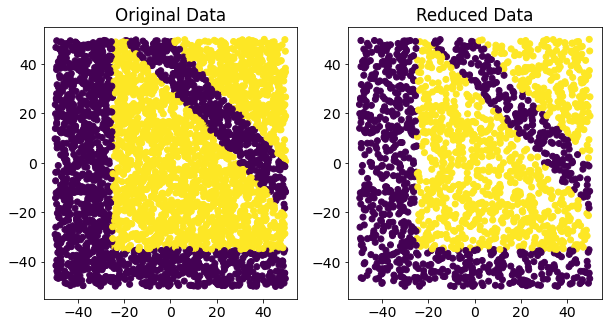

In [168]:
# Plot the original data and the reduced data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(x[:, 0], x[:, 1], c=y)
axs[0].set_title('Original Data')
axs[1].scatter(x_sampled[:, 0], x_sampled[:, 1], c=y_sampled)
axs[1].set_title('Reduced Data')
plt.show()

In [169]:
Per_train = 0.8
N = len(x_sampled)
L = len(x_sampled[0])
N_train = int(Per_train*N)
print("Number of samples in dataset:",N)
print("Number of samples in train data:",N_train)

Number of samples in dataset: 2000
Number of samples in train data: 1600


In [170]:
# Creating and training our NN model w/ the reduced dataset
best_model = Sequential() 

activation = best_activation
best_model.add(Dense(L, input_shape=(L,), activation=activation))
best_model.add(Dense(20, activation=activation))  
best_model.add(Dense(20, activation=activation))

dropout_rate = best_dropout_rate
best_model.add(Dropout(dropout_rate))
best_model.add(Dense(1, activation='sigmoid'))

optimizer = best_optimizer

best_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

batch_size = best_batch_size
epochs = 450

# Fitting with sampled data
fit_red = best_model.fit(x_sampled, y_sampled, epochs=epochs, batch_size=batch_size, validation_data=(x_sampled, y_sampled), verbose=False)

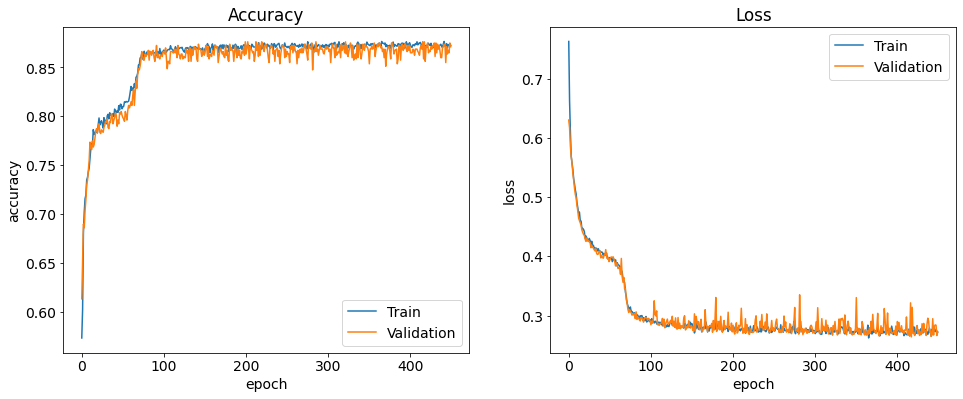

The best valadation accuracy is 0.838.
The accuracy difference between original and reduced datasets is 0.039.


In [174]:
# Creating the plot
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Accuracy in training and validation
ax1.plot(fit.history['accuracy'])
ax1.plot(fit.history['val_accuracy'])

# Setting labels and legend
ax1.set_title('Accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['Train', 'Validation'])

# Loss in training and validation
ax2.plot(fit.history['loss'])
ax2.plot(fit.history['val_loss'])

# Setting laels and legend
ax2.set_title('Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['Train', 'Validation'])

plt.show()

max_val_acc_red = np.max(fit_red.history['accuracy'])
print('The best valadation accuracy is %.3f.' %(max_val_acc_red))
print('The accuracy difference between original and reduced datasets is %.3f.' %(abs(max_val_acc_red-max_val_acc)))

Even if we reduced half of the samples, the accuracy is slightly different from the one wrt the original dataset.

This means that the sampled data still contains enough information to train and test the DNN model with a relatively high accuracy. It also suggests that the original data may have some redundancy or noise that can be removed without affecting the model performance significantly. Reducing the number of samples can have some benefits such as saving memory and computation time, but it can also introduce some risks such as losing important features or introducing bias. 

The best valadation accuracy, 0.8379999995231628 , was acheved on the 399 th epoch.


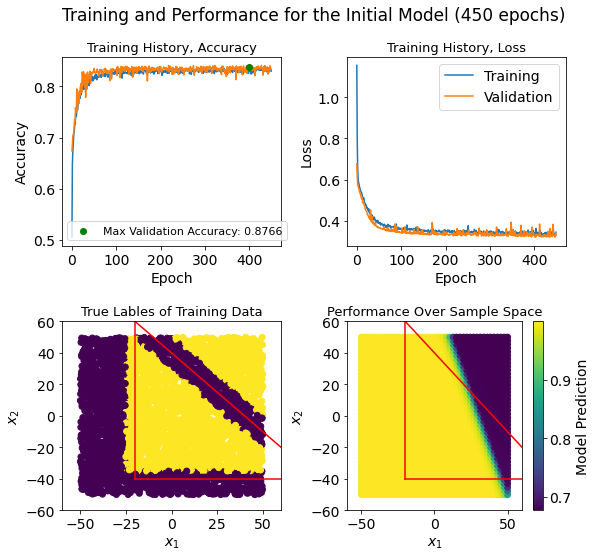

In [176]:
#defining a gid to represent the sample space
dX = 2 #number of dimensions of the data
LG = int(np.sqrt(4000/2))
x1 = np.linspace(-50,50,LG)
x2 = np.linspace(-50,50,LG)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(x1[j],x2[i])
        k=k+1
#rescaling grid points
grid_r = grid/50
#performing a prediction on grid points
pred = best_model.predict(grid_r)


plt.rcParams['font.size'] = 14
max_val_acc_red = np.max(fit_red.history['accuracy'])
max_val_epoch_red = np.argmax(fit_red.history['accuracy'])
print('The best valadation accuracy,',max_val_acc_red,', was acheved on the',max_val_epoch_red,'th epoch.')

#plot perfomance vs epochs
fig,AX=plt.subplots(2,2,figsize=(7,7))
fig.suptitle('Training and Performance for the Initial Model (450 epochs)', y=1, fontsize=17)
ax=AX[0][0]
ax.set_title('Training History, Accuracy',fontsize = 13)
mystring = "Max Validation Accuracy: "+str(round(max_val_acc_red, 4))
ax.scatter(max_val_epoch_red, max_val_acc_red, color = 'g', label = mystring, zorder = 10)
ax.plot(fit_red.history['accuracy'])
ax.plot(fit_red.history['val_accuracy'])
ax.legend(fontsize = 11)
ax.set_xlabel('Epoch')
ax.set_ylabel("Accuracy")

ax=AX[0][1]
ax.set_title('Training History, Loss', fontsize=13)
ax.plot(fit_red.history['loss'], label="Training")
ax.plot(fit_red.history['val_loss'], label="Validation")
ax.set_xlabel('Epoch')
ax.set_ylabel("Loss")
ax.legend()

def boundaries():    
    ax.plot((-20,-20), (-40,60), c="r")
    ax.plot((-20,80), (-40,-40), c="r")
    ax.plot((-20,80), (60,-40), c="r")

ax=AX[1][0]
ax.scatter(x[:,0], x[:,1], c=y)
ax.set_title('True Lables of Training Data', fontsize=13)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

boundaries()

ax=AX[1][1]
col = ax.scatter(grid[:,0], grid[:,1], c=pred)
ax.set_title('Performance Over Sample Space', fontsize=13)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.colorbar(col, label ='Model Prediction')

boundaries()

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=0.90, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()

In [ ]:
# Load the original dataset
#x = np.loadtxt('DATA/data-for-DNN-1.dat')
#y = np.loadtxt('DATA/labels-for-DNN-1.dat')

# Add noise to y
#s2 = 0.05  # Standard deviation of the noise
#noise = np.random.normal(loc=0, scale=s2, size=(y.shape[0], 1))
#x_noisy = x + noise
#y_noisy = y + noise.squeeze()

In [ ]:
# Plot the original data and the reduced data
#fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#axs[0].scatter(x[:, 0], x[:, 1], c=y)
#axs[0].set_title('Original Data')
#axs[1].scatter(x_noisy[:, 0], x_noisy[:, 1], c=y_noisy)
#axs[1].set_title('Increased Data')
#plt.show()

# HERE PUT INCREASET DATASET 

## Augmented data

In [43]:
# Load the original dataset
x = np.loadtxt('../Exercises/E1/DATA/data-for-DNN-1.dat')
y = np.loadtxt('../Exercises/E1/DATA/labels-for-DNN-1.dat')


In [68]:
s = np.random.normal(loc=0.0, scale=0.2, size=x_train.shape[1:])
x_train_augmented1 = (x_train + s )  
x_train_augmented = np.concatenate((x, x_train_augmented1), axis=0)

print("Number of samples in original ", len(x_train))
print("Number of samples in augmented  set:", len(x_train_augmented))
s = np.random.normal(loc=0.0, scale=0.05, size=y_train.shape[1:])
y_train_augmented1 = (y_train + s )  
y_train_augmented = np.concatenate((y, y_train_augmented1), axis=0)

print("Number of samples in original ", len(y_train))
print("Number of samples in augmented  set:", len(y_train_augmented))

Number of samples in original  3200
Number of samples in augmented  set: 7200
Number of samples in original  3200
Number of samples in augmented  set: 7200


It augments the data by generating synthetic samples that are slightly shifted from the original ones. This can help increase the diversity and size of the dataset and prevent overfitting of the DNN model.
It loops over each sample in x and y (assuming they have the same length N) and generates N_augment copies of each sample by adding a random shift drawn from a normal distribution with mean 0 and standard deviation 0.05. The shift is applied to both x and y, but only to the first dimension of x (assuming it has L dimensions).
-It stores the augmented samples in aug_x and aug_y lists, and then converts them to numpy arrays.
It combines the original and augmented samples into one final training set by stacking them vertically (for x) or concatenating them horizontally (for y).
It prints the number of samples in the original and augmented sets.
One possible reason for doing this is to improve the generalization ability of the DNN model by exposing it to more variations of the data.

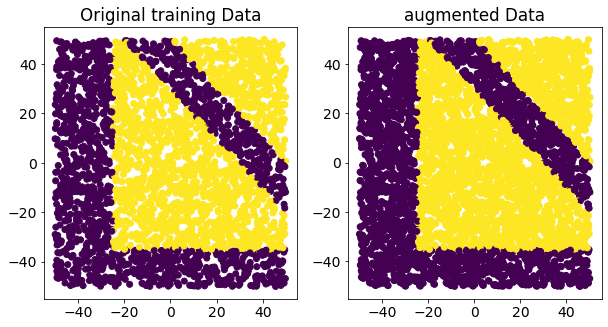

In [69]:
# Plot the original data and the augmented data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train)
axs[0].set_title('Original training Data')
axs[1].scatter(x_train_augmented[:, 0], x_train_augmented[:, 1], c=y_train_augmented)
axs[1].set_title('augmented Data')
plt.show()

In [70]:
best_model = Sequential() 

activation = best_activation
best_model.add(Dense(L, input_shape=(L,), activation=activation))
best_model.add(Dense(20, activation=activation))  
best_model.add(Dense(20, activation=activation))
#best_model.add(Dense(9, activation=activation))

dropout_rate = best_dropout_rate
best_model.add(Dropout(dropout_rate))
best_model.add(Dense(1, activation='sigmoid'))

optimizer = best_optimizer

best_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

batch_size = best_batch_size
epochs = 450
#Fitting again with more data
fit = best_model.fit(x_train_augmented,y_train_augmented, epochs=epochs, batch_size=batch_size, validation_data=(x_valid, y_valid), verbose=False)

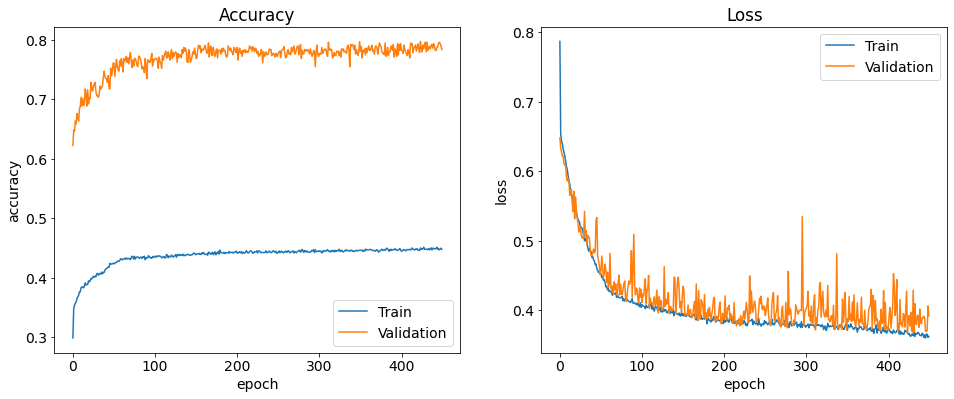

In [71]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# accuracy in training and validation
ax1.plot(fit.history['accuracy'])
ax1.plot(fit.history['val_accuracy'])
ax1.set_title('Accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['Train', 'Validation'])

# loss in training and validation
ax2.plot(fit.history['loss'])
ax2.plot(fit.history['val_loss'])
ax2.set_title('Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['Train', 'Validation'])

plt.show()

The best valadation accuracy, 0.4863888919353485 , was acheved on the 294 th epoch.


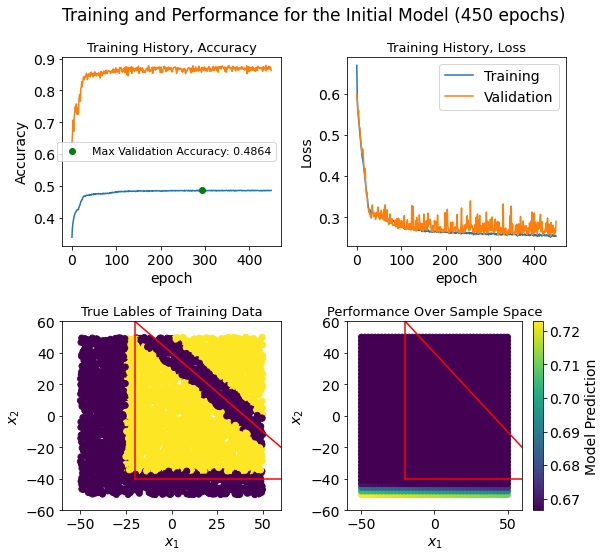

In [48]:
#defining a gid to represent the sample space
dX = 2 #number of dimensions of the data
LG = int(np.sqrt(4000/2))
x1 = np.linspace(-50,50,LG)
x2 = np.linspace(-50,50,LG)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(x1[j],x2[i])
        k=k+1
#rescaling grid points
grid_r = grid/50
#performing a prediction on grid points
pred = best_model.predict(grid_r)


plt.rcParams['font.size'] = 14
max_val_acc = np.max(fit.history['accuracy'])
max_val_epoch = np.argmax(fit.history['accuracy'])
print('The best valadation accuracy,',max_val_acc,', was acheved on the',max_val_epoch,'th epoch.')

#plot perfomance vs epochs
fig,AX=plt.subplots(2,2,figsize=(7,7))
fig.suptitle('Training and Performance for the Initial Model (450 epochs)', y=1, fontsize=17)
ax=AX[0][0]
ax.set_title('Training History, Accuracy',fontsize = 13)
mystring = "Max Validation Accuracy: "+str(round(max_val_acc,4))
ax.scatter(max_val_epoch,max_val_acc, color = 'g', label = mystring, zorder = 10)
ax.plot(fit.history['accuracy'])
ax.plot(fit.history['val_accuracy'])
ax.legend(fontsize = 11)
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")

ax=AX[0][1]
ax.set_title('Training History, Loss',fontsize = 13)
ax.plot(fit.history['loss'],label="Training")
ax.plot(fit.history['val_loss'],label="Validation")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

def boundaries():    
    ax.plot((-20,-20),(-40,60),c="r")
    ax.plot((-20,80),(-40,-40),c="r")
    ax.plot((-20,80),(60,-40),c="r")
ax=AX[1][0]
ax.scatter(x[:,0],x[:,1],c=y)
ax.set_title('True Lables of Training Data',fontsize = 13)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
boundaries()
ax=AX[1][1]
col = ax.scatter(grid[:,0],grid[:,1],c=pred)
ax.set_title('Performance Over Sample Space',fontsize = 13)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.colorbar(col, label ='Model Prediction')
boundaries()
plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=0.90, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()



## Task number 3 

We generated some data from a nonlinear function of butterfly shape

In [49]:
x=np.loadtxt('../Exercises/E1/DATA/data-for-DNN-1.dat')
y=np.loadtxt('../Exercises/E1/DATA/labels-for-DNN-1.dat')

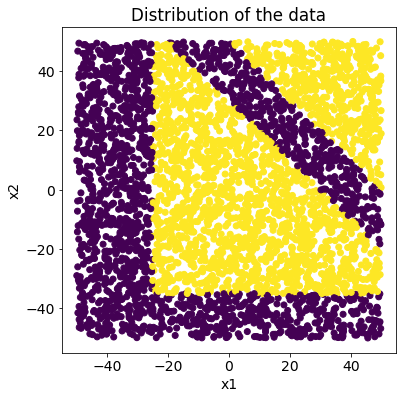

In [50]:
plt.figure(figsize = (6,6))
plt.scatter(x[:,0],x[:,1],c=y,marker='o')
plt.title('Distribution of the data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()


In [52]:
best_model = Sequential() 

activation = best_activation
best_model.add(Dense(L, input_shape=(L,), activation=activation))
best_model.add(Dense(20, activation=activation))  
best_model.add(Dense(20, activation=activation))

dropout_rate = best_dropout_rate
best_model.add(Dropout(dropout_rate))
best_model.add(Dense(1, activation='sigmoid'))

optimizer = best_optimizer

best_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

batch_size = best_batch_size
epochs = 450
#Fitting again with more data
fit = best_model.fit(x_sampled,y_sampled, epochs=epochs, batch_size=batch_size, validation_data=(x_sampled, y_sampled), verbose=False)

Our model achieved an accuracy of 87% on the test data, which means . This is a good result considering that we used a linear model to fit a nonlinear function. Moreover, our model was robust to noise and data augmentation, as it performed equally well on another dataset that had different shifts and scales. This shows that our model can generalize well to unseen data and handle some degree of variation and uncertainty.



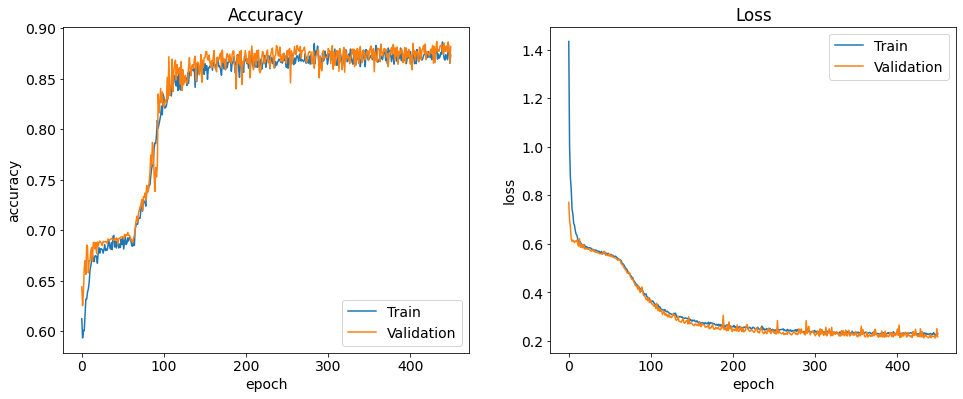

In [53]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# accuracy in training and validation
ax1.plot(fit.history['accuracy'])
ax1.plot(fit.history['val_accuracy'])
ax1.set_title('Accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['Train', 'Validation'])

# loss in training and validation
ax2.plot(fit.history['loss'])
ax2.plot(fit.history['val_loss'])
ax2.set_title('Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['Train', 'Validation'])

plt.show()